## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

## Load Data

In [2]:
data = pd.read_csv(r"C:\Users\asus\Downloads\Statistical_computing.csv", skiprows = 12)

In [3]:
data

,PARAMETER,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
0,T2M,2018,19.38,22.71,26.41,29.24,29.33,25.46,23.54,22.90,23.06,23.64,22.07,19.55,23.94
1,T2M,2019,19.88,22.99,26.37,29.60,28.98,26.90,24.17,23.40,23.43,23.05,21.42,20.62,24.23
2,T2M,2020,18.65,21.65,24.37,29.40,29.79,25.01,24.11,23.55,23.71,23.62,21.33,19.52,23.73
3,T2M,2021,21.28,21.51,26.52,28.70,27.57,24.82,23.86,23.28,23.30,23.01,22.14,19.27,23.78
4,T2M,2022,18.12,20.58,26.85,29.59,28.47,26.10,23.50,23.22,23.24,22.04,19.71,20.39,23.50
5,QV2M,2018,8.06,7.63,8.12,9.16,12.82,17.94,17.76,17.09,16.11,13.31,10.62,7.63,12.21
6,QV2M,2019,5.43,6.47,6.53,8.97,12.02,16.66,18.49,17.82,17.94,16.54,14.04,13.00,12.88
7,QV2M,2020,10.31,9.16,9.77,10.19,13.55,17.70,18.07,18.25,18.07,16.85,13.67,11.17,13.92
8,QV2M,2021,11.66,8.48,7.87,10.31,15.75,18.19,18.07,17.21,17.64,15.75,14.65,11.47,13.98
9,QV2M,2022,9.64,8.42,8.42,9.77,14.47,16.54,17.82,17.58,17.46,15.32,11.84,11.78,13.31


## Rename columns and clean up any extra whitespace

In [4]:
data.columns = data.columns.str.strip()
data.replace(-999, np.nan, inplace = True) # Handle missing values (-999)

## Convert data from wide to long format for ease of analysis

In [5]:
month_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
data_long = pd.melt(data, id_vars=["PARAMETER", "YEAR"], value_vars=month_cols, var_name="MONTH", value_name="VALUE")

In [6]:
data_long

,PARAMETER,YEAR,MONTH,VALUE
0,T2M,2018,JAN,19.38
1,T2M,2019,JAN,19.88
2,T2M,2020,JAN,18.65
3,T2M,2021,JAN,21.28
4,T2M,2022,JAN,18.12
...,...,...,...,...
235,ALLSKY_SFC_SW_DWN,2018,DEC,195.08
236,ALLSKY_SFC_SW_DWN,2019,DEC,169.51
237,ALLSKY_SFC_SW_DWN,2020,DEC,183.10
238,ALLSKY_SFC_SW_DWN,2021,DEC,171.30


## Convert month names to numerical format

In [7]:
month_mapping = {month: i+1 for i, month in enumerate(month_cols)}
data_long["MONTH"] = data_long["MONTH"].map(month_mapping)

In [8]:
data_long

,PARAMETER,YEAR,MONTH,VALUE
0,T2M,2018,1,19.38
1,T2M,2019,1,19.88
2,T2M,2020,1,18.65
3,T2M,2021,1,21.28
4,T2M,2022,1,18.12
...,...,...,...,...
235,ALLSKY_SFC_SW_DWN,2018,12,195.08
236,ALLSKY_SFC_SW_DWN,2019,12,169.51
237,ALLSKY_SFC_SW_DWN,2020,12,183.10
238,ALLSKY_SFC_SW_DWN,2021,12,171.30


## Separate data based on parameters for analysis

In [9]:
temp_data = data_long[data_long["PARAMETER"] == "T2M"]
irradiance_data = data_long[data_long["PARAMETER"] == "ALLSKY_SFC_SW_DWN"]

In [10]:
temp_data

,PARAMETER,YEAR,MONTH,VALUE
0,T2M,2018,1,19.38
1,T2M,2019,1,19.88
2,T2M,2020,1,18.65
3,T2M,2021,1,21.28
4,T2M,2022,1,18.12
20,T2M,2018,2,22.71
21,T2M,2019,2,22.99
22,T2M,2020,2,21.65
23,T2M,2021,2,21.51
24,T2M,2022,2,20.58


In [11]:
irradiance_data

,PARAMETER,YEAR,MONTH,VALUE
15,ALLSKY_SFC_SW_DWN,2018,1,201.40
16,ALLSKY_SFC_SW_DWN,2019,1,213.53
17,ALLSKY_SFC_SW_DWN,2020,1,205.09
18,ALLSKY_SFC_SW_DWN,2021,1,188.40
19,ALLSKY_SFC_SW_DWN,2022,1,199.80
35,ALLSKY_SFC_SW_DWN,2018,2,235.88
36,ALLSKY_SFC_SW_DWN,2019,2,245.23
37,ALLSKY_SFC_SW_DWN,2020,2,231.26
38,ALLSKY_SFC_SW_DWN,2021,2,231.38
39,ALLSKY_SFC_SW_DWN,2022,2,247.10


## Temperature Trends Over Time

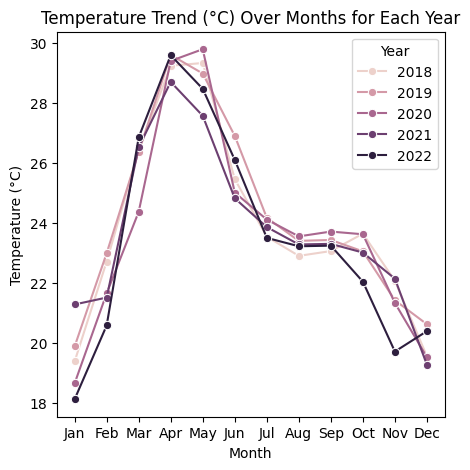

In [12]:
unique_years = irradiance_data["YEAR"].unique()

plt.figure(figsize = (5,5))
sns.lineplot(data = temp_data, x = "MONTH", y = "VALUE", hue = "YEAR", marker = "o")
plt.title("Temperature Trend (°C) Over Months for Each Year")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.legend(title = "Year")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

## Solar Irradiance Trends Over Time

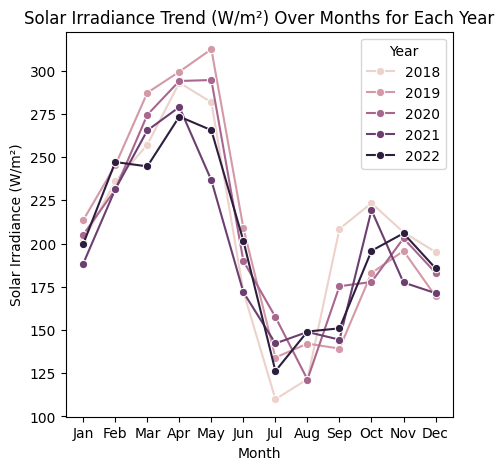

In [13]:
plt.figure(figsize = (5,5))
sns.lineplot(data = irradiance_data, x = "MONTH", y = "VALUE", hue = "YEAR", marker = "o")
plt.title("Solar Irradiance Trend (W/m²) Over Months for Each Year")
plt.xlabel("Month")
plt.ylabel("Solar Irradiance (W/m²)")
plt.legend(title = "Year")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

## Annual Summary of Each Parameter

C:\Users\asus\AppData\Local\Temp\ipykernel_12532\3910136661.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
C:\Users\asus\AppData\Local\Temp\ipykernel_12532\3910136661.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])


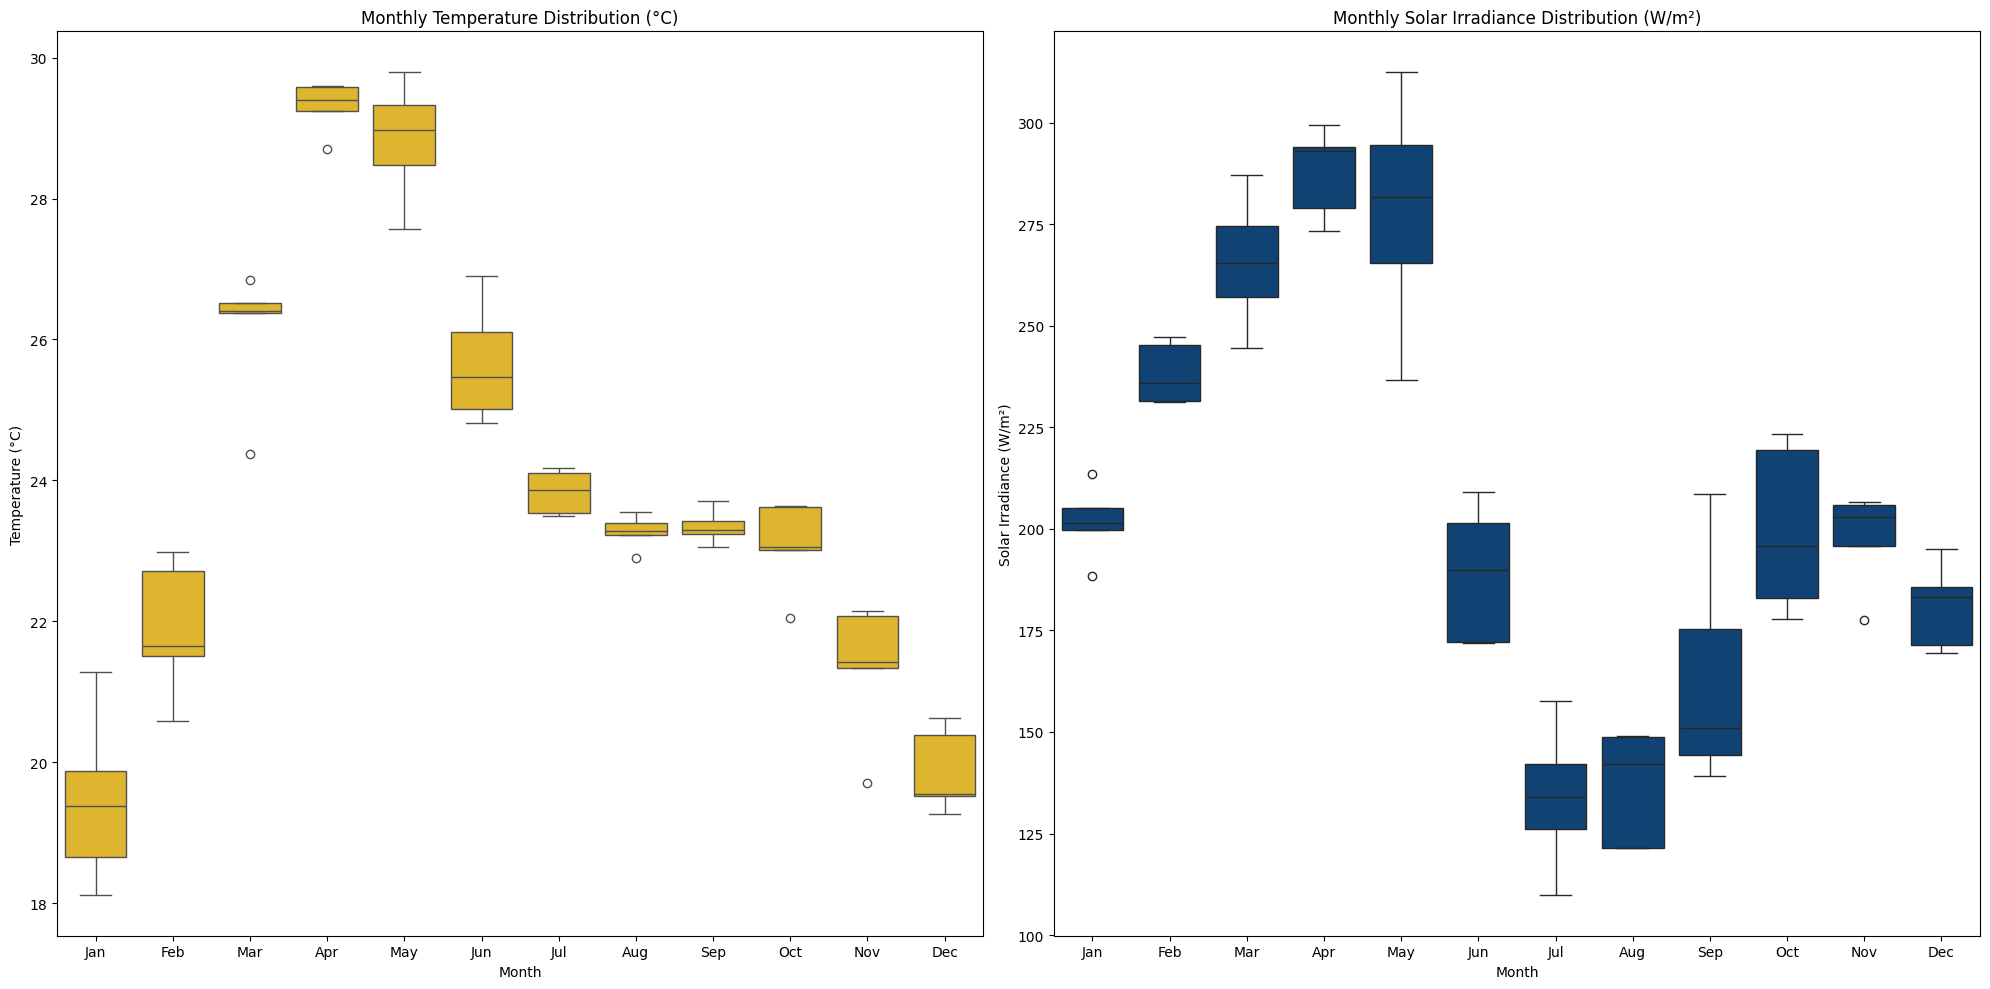

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (20,10))
sns.boxplot(data = temp_data, x = "MONTH", y = "VALUE", ax = ax[0], color = "#FAC511")
ax[0].set_title("Monthly Temperature Distribution (°C)")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Temperature (°C)")
ax[0].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

sns.boxplot(data=irradiance_data, x = "MONTH", y = "VALUE", ax = ax[1], color = "#004383")
ax[1].set_title("Monthly Solar Irradiance Distribution (W/m²)")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Solar Irradiance (W/m²)")
ax[1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.tight_layout()
plt.show()

## Direct Search for Optimal Solar Irridiance Condition

In [15]:
optimal_irradiance_month = irradiance_data.loc[irradiance_data["VALUE"].idxmax()]
print("Optimal Month for Solar Irradiance:")
print(optimal_irradiance_month)

Optimal Month for Solar Irradiance:
PARAMETER    ALLSKY_SFC_SW_DWN
YEAR                      2019
MONTH                        5
VALUE                   312.34
Name: 96, dtype: object


## Grid Search for Optimal Conditions (Example for Temperature)

In [16]:
param_grid = {'MONTH': range(1,13)}
grid = ParameterGrid(param_grid)
opt_conditions = []
for params in grid:
    month = params['MONTH']
    temp_in_month = temp_data[temp_data["MONTH"] == month]["VALUE"].mean()
    opt_conditions.append((month, temp_in_month))
opt_conditions = sorted(opt_conditions, key = lambda x: x[1], reverse = True)

print("Optimal month(s) for high temperature (grid search):")
for condition in opt_conditions[:5]: # Top 3 months with highest temperature
    print(f"Month: {condition[0]}, Average Temperature: {condition[1]:.2f} °C")
    

Optimal month(s) for high temperature (grid search):
Month: 4, Average Temperature: 29.31 °C
Month: 5, Average Temperature: 28.83 °C
Month: 3, Average Temperature: 26.10 °C
Month: 6, Average Temperature: 25.66 °C
Month: 7, Average Temperature: 23.84 °C


## Gradient - Based Search for Temperature Trends 

In [17]:
temp_data = temp_data.sort_values(by = ["YEAR", "MONTH"])
temp_data["TIME"] = range(len(temp_data))
x = temp_data["TIME"].values
y = temp_data["VALUE"].values

# Define a simple linear trend model for demonstration
def linear_trend(time, m, c):
    return m * time + c

# Objective function to minimize (mean squared error)
def objective(params):
    m, c = params
    predicted = linear_trend(x, m, c)
    return np.mean((y-predicted) ** 2)

# Run gradient-based optimization
initial_guess = [0, y.mean()]
result = minimize(objective, initial_guess, method='BFGS') #Broyden-Fletcher-Goldfarb-Shanno
slope, intercept = result.x

print("\nTemperature trend:")
print(f"Slope: {slope:.4f}, Intercept: {intercept:.2f}")
print("Negative slope indicates decreasing temperature over time.")



Temperature trend:
Slope: -0.0207, Intercept: 24.44
Negative slope indicates decreasing temperature over time.


## Plot the Trend Line on the Temperature Data

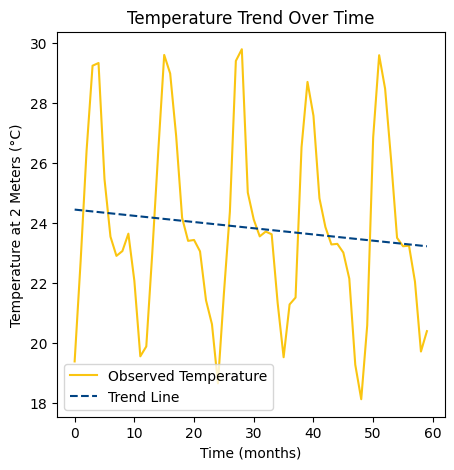

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(temp_data["TIME"], temp_data["VALUE"], label="Observed Temperature", color = "#FAC511")
plt.plot(temp_data["TIME"], linear_trend(x, slope, intercept), color="#004383", linestyle='--', label="Trend Line")
plt.xlabel("Time (months)")
plt.ylabel("Temperature at 2 Meters (°C)")
plt.title("Temperature Trend Over Time")
plt.legend()
plt.show()

## ARIMA (AutoRegressive Integrated Moving Average)

### Fitting of a Model

In [19]:
# Ensure data is sorted by time (important for ARIMA models)
temp_data_monthly = temp_data.groupby(['YEAR', 'MONTH'])['VALUE'].mean().reset_index()
temp_data_monthly['TIME'] = range(len(temp_data_monthly))  # Create a time index
temp_series = temp_data_monthly['VALUE']  # Temperature values

p, d, q = 8, 0, 8  # Example values based on general guidelines
model = ARIMA(temp_series, order=(p, d, q))
arima_result = model.fit()

# Print model summary
print(arima_result.summary())

C:\Users\asus\anaconda3\envs\r-tutorial\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asus\anaconda3\envs\r-tutorial\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                   60
Model:                 ARIMA(8, 0, 8)   Log Likelihood                 -77.429
Date:                Thu, 05 Dec 2024   AIC                            190.859
Time:                        21:27:53   BIC                            228.557
Sample:                             0   HQIC                           205.605
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8242      0.141    169.048      0.000      23.548      24.100
ar.L1         -0.2778      0.540     -0.514      0.607      -1.337       0.781
ar.L2          0.4447      0.413      1.077      0.2

C:\Users\asus\anaconda3\envs\r-tutorial\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Assumption 1: Stationarity Check using Augmented Dickey-Fuller Test

#### Null Hypothesis: Residuals are not Stationary      &                                                                                                                              Alternative Hypothesis: Residuals are Stationary

In [20]:
# Perform Augmented Dickey-Fuller test on residuals
adf_result = adfuller(arima_result.resid)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Critical Values: {adf_result[4]}')

# Conclusion for Stationarity:
if adf_result[1] < 0.05:
    print("Residuals are stationary (null hypothesis rejected).")
else:
    print("Residuals are not stationary (fail to reject null hypothesis).")


ADF Statistic: -9.22130577953148
p-value: 1.7769249952696027e-15
Critical Values: {'1%': np.float64(-3.5463945337644063), '5%': np.float64(-2.911939409384601), '10%': np.float64(-2.5936515282964665)}
Residuals are stationary (null hypothesis rejected).


In [21]:
adf_result

(np.float64(-9.22130577953148),
 np.float64(1.7769249952696027e-15),
 0,
 59,
 {'1%': np.float64(-3.5463945337644063),
  '5%': np.float64(-2.911939409384601),
  '10%': np.float64(-2.5936515282964665)},
 np.float64(120.71529383986501))

### Assumption 2: Check if Residuals are Uncorrelated using ACF and PACF plots

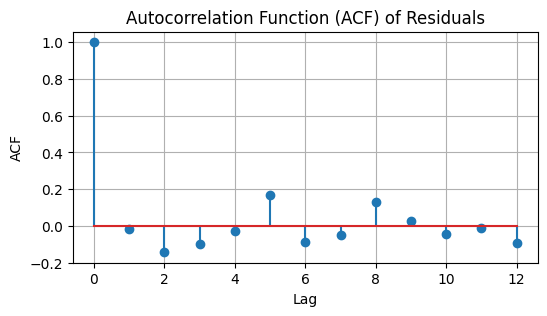

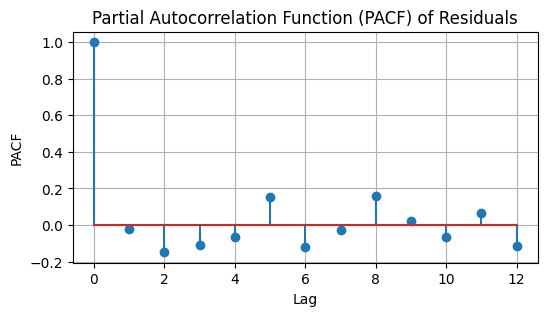

In [22]:
max_lags = 12

# ACF and PACF of the residuals
acf_residuals = acf(arima_result.resid, nlags=max_lags)
pacf_residuals = pacf(arima_result.resid, nlags=max_lags)

# Plotting ACF
plt.figure(figsize=(6, 3))
plt.stem(range(len(acf_residuals)), acf_residuals)
plt.title("Autocorrelation Function (ACF) of Residuals")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.grid()
plt.show()

# Plotting PACF
plt.figure(figsize=(6, 3))
plt.stem(range(len(pacf_residuals)), pacf_residuals)
plt.title("Partial Autocorrelation Function (PACF) of Residuals")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.grid()
plt.show()


### Assumption 3: Check for Outliers in Residuals using a Boxplot

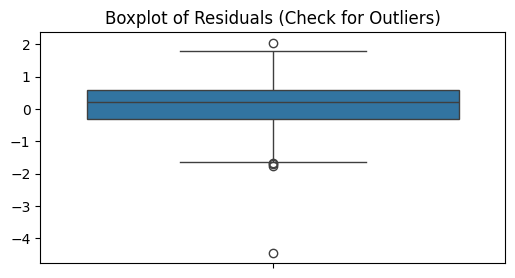

In [23]:

# Plotting Boxplot for Residuals to check for Outliers
plt.figure(figsize=(6, 3))
boxplot = sns.boxplot(arima_result.resid)
plt.title('Boxplot of Residuals (Check for Outliers)')
plt.show()


### Assumption 4: White Noise

#### Null Hypothesis: There is no Autocorrelation and Series is a White Noise Series  &  Alternative Hypothesis: There exist an Autocorrelation and Series is not White Noise Series 

In [24]:

# Define the number of lags for the Ljung-Box test
lags = 12

# Perform Ljung-Box Test
ljungbox_result = acorr_ljungbox(arima_result.resid, lags=lags, return_df=True)

# Display the results
print(f"Ljung-Box Test Statistic: {ljungbox_result['lb_stat'].values}")
print(f"Ljung-Box p-values: {ljungbox_result['lb_pvalue'].values}")

# Conclusion for Random Shocks
if all(ljungbox_result['lb_pvalue'] > 0.05):
    print("\nResiduals are uncorrelated (series is a white noise series).")
else:
    print("\nResiduals are correlated (series is not a white noise series).")


Ljung-Box Test Statistic: [0.02274485 1.34028988 1.95381023 2.01361744 3.88141448 4.4428621
 4.6329963  5.85927381 5.91106804 6.06093658 6.06674668 6.74463535]
Ljung-Box p-values: [0.88012248 0.51163442 0.58204869 0.73325411 0.56661273 0.61697293
 0.70464873 0.66299178 0.74878496 0.81011788 0.86887377 0.87401745]

Residuals are uncorrelated (series is a white noise series).


### Forecasting

Forecasted Temperature
Month 1: 19.15 °C
Month 2: 22.32 °C
Month 3: 26.31 °C
Month 4: 28.80 °C
Month 5: 28.22 °C
Month 6: 26.40 °C
Month 7: 23.65 °C
Month 8: 23.51 °C
Month 9: 23.77 °C
Month 10: 23.03 °C
Month 11: 21.24 °C
Month 12: 19.44 °C
Month 13: 19.21 °C
Month 14: 22.31 °C
Month 15: 26.43 °C
Month 16: 28.46 °C
Month 17: 28.53 °C
Month 18: 26.02 °C
Month 19: 23.92 °C
Month 20: 23.55 °C
Month 21: 23.91 °C
Month 22: 22.90 °C
Month 23: 21.42 °C
Month 24: 19.16 °C


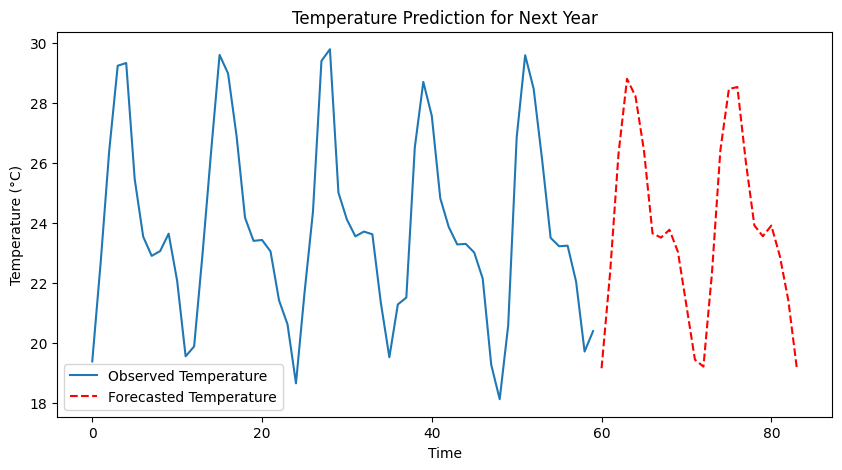

In [25]:
forecast_steps = 24
forecast = arima_result.forecast(steps=forecast_steps)

print("Forecasted Temperature")
for month, temp in enumerate(forecast, start=1):
    print(f"Month {month}: {temp:.2f} °C")


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(temp_series, label="Observed Temperature")
plt.plot(range(len(temp_series), len(temp_series) + forecast_steps), forecast, label="Forecasted Temperature", linestyle='--', color='red')
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Prediction for Next Year")
plt.legend()
plt.show()